<a href="https://colab.research.google.com/github/Viroslav/Projects/blob/main/ML(10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib.request import urlopen

import numpy as np

%matplotlib inline
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston, load_digits, load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


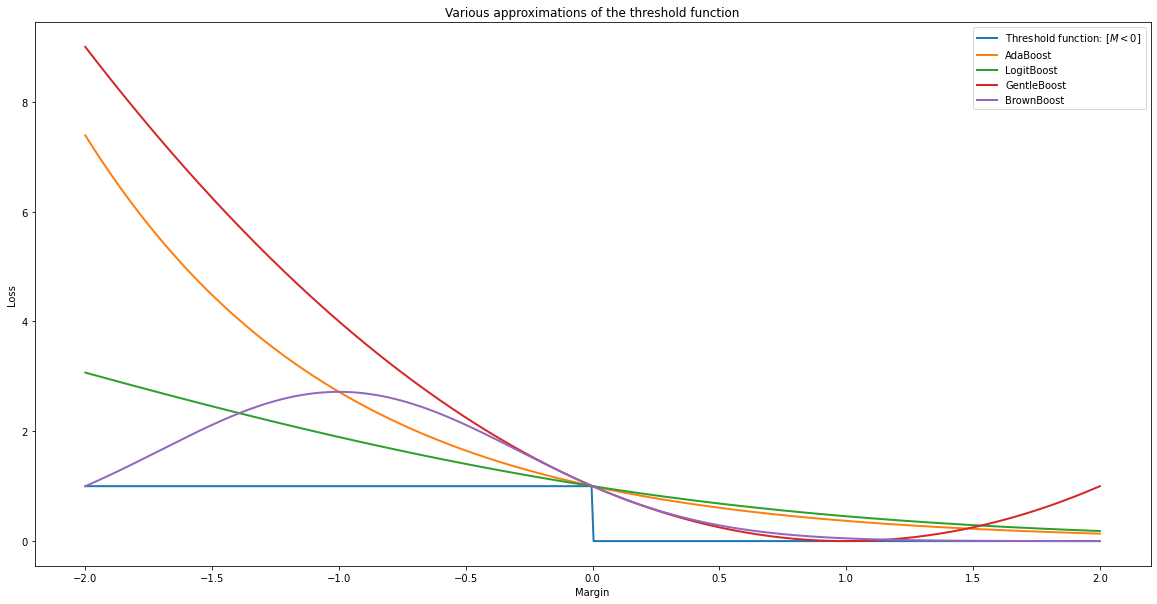

In [ ]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(20, 10))
plt.plot(x, x < 0, lw=2, label="Threshold function: $[M < 0$]")
plt.plot(x, np.exp(-x), lw=2, label="AdaBoost")
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label="LogitBoost")
plt.plot(x, (1 - x) ** 2, lw=2, label="GentleBoost")
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label="BrownBoost")
plt.title("Various approximations of the threshold function")
plt.legend(loc="best")
plt.xlabel("Margin")
plt.ylabel("Loss");

## Grad Boosting

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


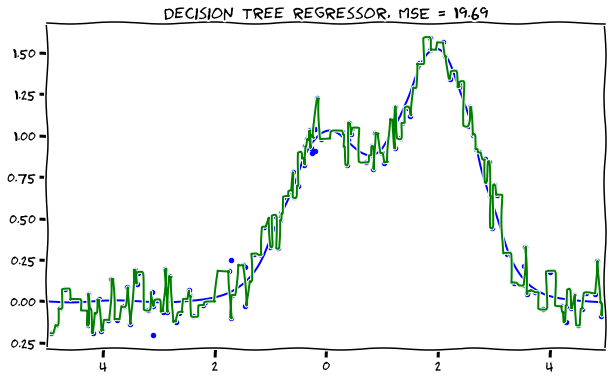

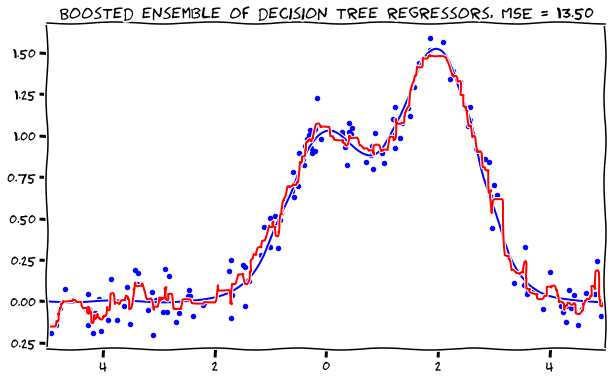

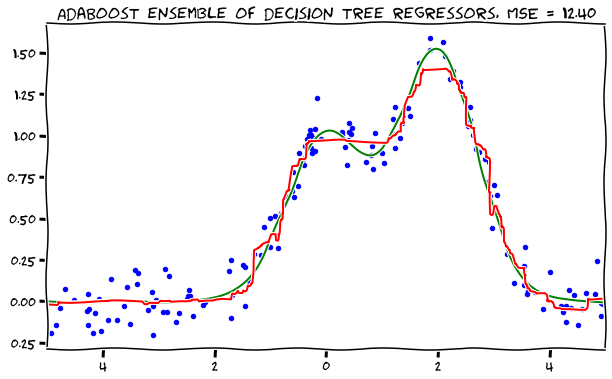

In [ ]:
n_train = 150
n_test = 1000
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = (
        np.exp(-(X ** 2))
        + 1.5 * np.exp(-((X - 2) ** 2))
        + np.random.normal(0.0, noise, n_samples)
    )
    X = X.reshape((n_samples, 1))

    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, d_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - d_predict) ** 2))

    gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5, random_state=42)
    gbtree.fit(X_train, y_train)
    gb_predict = gbtree.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, gb_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title(
        "Boosted ensemble of decision tree regressors, MSE = %.2f"
        % np.sum((y_test - gb_predict) ** 2)
    );


    abtree = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss='square', random_state=42)
    abtree.fit(X_train, y_train)
    ab_predict = abtree.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "g")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, ab_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title(
        "AdaBoost ensemble of decision tree regressors, MSE = %.2f"
        % np.sum((y_test - ab_predict) ** 2));

#XGboost

In [ ]:
import time

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm_notebook

xgb_params1 = {
    "booster": "gbtree",
    "max_depth": 3,
    "eta": 0.1,
    "silent": 1,
    "objective": "binary:logistic",
    "nthread": 1,
}
xgb_params2 = {
    "booster": "gbtree",
    "max_depth": 3,
    "eta": 0.1,
    "silent": 1,
    "objective": "binary:logistic",
    "nthread": 4,
}
sklearn_params = {"n_estimators": 100, "max_depth": 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in tqdm_notebook(range(n_runs)):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

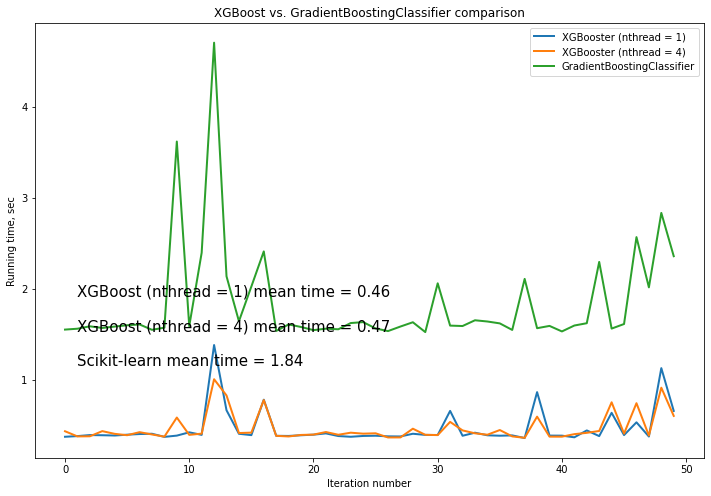

In [ ]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label="XGBooster (nthread = 1)", lw=2)
plt.plot(xgb_time2, label="XGBooster (nthread = 4)", lw=2)
plt.plot(sklearn_time, label="GradientBoostingClassifier", lw=2)
plt.legend(loc="best")
plt.text(
    1,
    (xgb_mean1 + sklearn_mean) / 2,
    "XGBoost (nthread = 1) mean time = %.2f" % xgb_mean1
    + "\n\nXGBoost (nthread = 4) mean time = %.2f" % xgb_mean2
    + "\n\nScikit-learn mean time = %.2f" % sklearn_mean,
    fontsize=15,
)
plt.xlabel("Iteration number")
plt.ylabel("Running time, sec")
plt.title("XGBoost vs. GradientBoostingClassifier comparison")
plt.show()

## Пример использования Xgboost для классификации на данных Iris.

In [ ]:
iris = load_iris()
X = iris["data"]
y = iris["target"]
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0 10  1]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


Пример восстановления регрессии с Xgboost на данных boston.

In [ ]:
boston = load_boston()
y = boston["target"]
X = boston["data"]
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8.129992031937604
[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
9.65223163719097
[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
17.839230414021902
[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6.857900911239092
[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8.673159469080009


Простой пример подбора параметров с GridSearchCV.

In [ ]:
X = boston["data"]
y = boston["target"]

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model, {"max_depth": [2, 4, 6]}, verbose=1)
xgb_grid.fit(X, y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:53] WARNING: /workspace/src/objective/regres

Ранняя остановка используется для того, чтобы прекратить обучение модели (градиентный спуск), если ошибка за несколько итераций не уменьшилась.

In [ ]:
digits = load_digits()

X = digits["data"]
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric="merror",
    eval_set=[(X_test, y_test)],
)

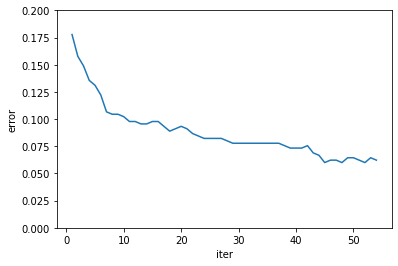

In [ ]:
errors_by_iter = clf.evals_result()["validation_0"]["merror"]
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
plt.xlabel("iter")
plt.ylabel("error")
plt.ylim(0, 0.2);

Telechurm

In [ ]:

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

Важно: XGBoost поддерживает только числовые признаки. Поэтому текстовые признаки требуют предобработки

Для обучения с Xgboost данные должны быть представлены в виде объекта DMatrix, предназначенного для представления разреженных данных. Его можно инициализировать через:

текстовый формат libsvm,
Numpy 2D array (чаще всего)
бинарный буфер-файл XGBoost

In [ ]:
url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/'
df = pd.read_csv(url + 'telecom_churn.csv')

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Штаты просто занумеруем (хотя можно и лучше поступить), а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.**

In [ ]:
state_enc = LabelEncoder()
df["State"] = state_enc.fit_transform(df["State"])
df["International plan"] = (df["International plan"] == "Yes").astype("int")
df["Voice mail plan"] = (df["Voice mail plan"] == "Yes").astype("int")
df["Churn"] = (df["Churn"]).astype("int")

In [ ]:
df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

**Разделим данные на обучающую и тестовую выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dtest.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Churn", axis=1),
    df["Churn"],
    test_size=0.3,
    stratify=df["Churn"],
    random_state=17,
)

In [ ]:
X_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls
2349,6,22,408,0,0,0,207.7,116,35.31,210.6,99,17.90,238.2,88,10.72,9.6,5,2.59,0
2691,7,102,415,0,0,0,186.8,92,31.76,173.7,123,14.76,250.9,131,11.29,9.7,4,2.62,2
1312,42,103,415,0,0,0,141.3,123,24.02,253.6,87,21.56,215.8,96,9.71,6.4,2,1.73,1
1803,0,101,510,0,0,0,174.9,105,29.73,262.0,75,22.27,210.0,93,9.45,8.5,5,2.30,1
835,10,27,510,0,0,0,72.7,75,12.36,208.6,117,17.73,65.8,71,2.96,9.9,3,2.67,1


In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [ ]:
dtrain

In [ ]:
dtrain.get_label()

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

**Посмотрим на статистику полученных объектов:**

In [ ]:
print(
    "Train dataset contains {0} rows and {1} columns".format(
        dtrain.num_row(), dtrain.num_col()
    )
)
print(
    "Test dataset contains {0} rows and {1} columns".format(
        dtest.num_row(), dtest.num_col()
    )
)

Train dataset contains 2333 rows and 19 columns
Test dataset contains 1000 rows and 19 columns


In [ ]:
print("Train mean target: ")
print(np.mean(dtrain.get_label()))

print("\nTest mean target: ")
print(np.mean(dtest.get_label()))

Train mean target: 
0.14487784

Test mean target: 
0.145


<span style="color: white; font-size: 40px;">Инициализация параметров</span>
<br><li>бинарная классификация ('objective':'binary:logistic')<l/i>
<br><li>ограничим глубину деревьев ('max_depth':3)</li>
<li>не хотим лишнего вывода ('silent':1)</li>
<li>проведем 50 итераций бустинга</li>
<li>шаг градиентного спуска довольно большой ('eta':1) - алгоритм будет обучаться быстро и "агрессивно" (лучше результаты будут, если уменьшить eta и увеличить число итераций)</li>

In [ ]:
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 1}

num_rounds = 50

**Обучение классификатора**

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)

**С помощью watchlist отслеживать качество алгоритма на тестовой выборке для каждой итерации.**

In [ ]:
watchlist = [(dtest, "test"), (dtrain, "train")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.116	train-error:0.09087
[1]	test-error:0.102	train-error:0.068581
[2]	test-error:0.071	train-error:0.040291
[3]	test-error:0.064	train-error:0.034719
[4]	test-error:0.071	train-error:0.036005
[5]	test-error:0.07	train-error:0.033862
[6]	test-error:0.069	train-error:0.032147
[7]	test-error:0.073	train-error:0.030433
[8]	test-error:0.07	train-error:0.028718
[9]	test-error:0.074	train-error:0.028718
[10]	test-error:0.07	train-error:0.02829
[11]	test-error:0.07	train-error:0.028718
[12]	test-error:0.063	train-error:0.026575
[13]	test-error:0.067	train-error:0.024432
[14]	test-error:0.069	train-error:0.02186
[15]	test-error:0.069	train-error:0.021432
[16]	test-error:0.068	train-error:0.02186
[17]	test-error:0.063	train-error:0.019288
[18]	test-error:0.07	train-error:0.021003
[19]	test-error:0.067	train-error:0.01886
[20]	test-error:0.069	train-error:0.019288
[21]	test-error:0.068	train-error:0.018003
[22]	test-error:0.065	train-error:0.016717
[23]	test-error:0.063	train-err

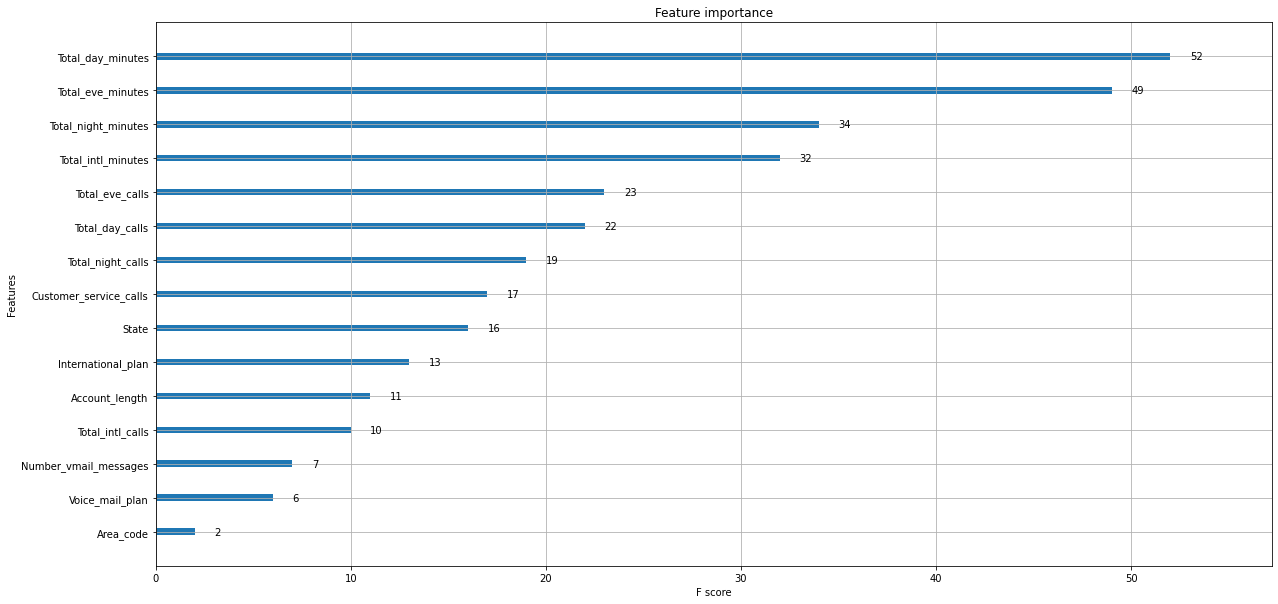

In [ ]:
rcParams['figure.figsize'] = 20,10
xgb.plot_importance(xgb_model); # F score - вычисляется на основе того, как часто разбиение делалось по данному признаку.

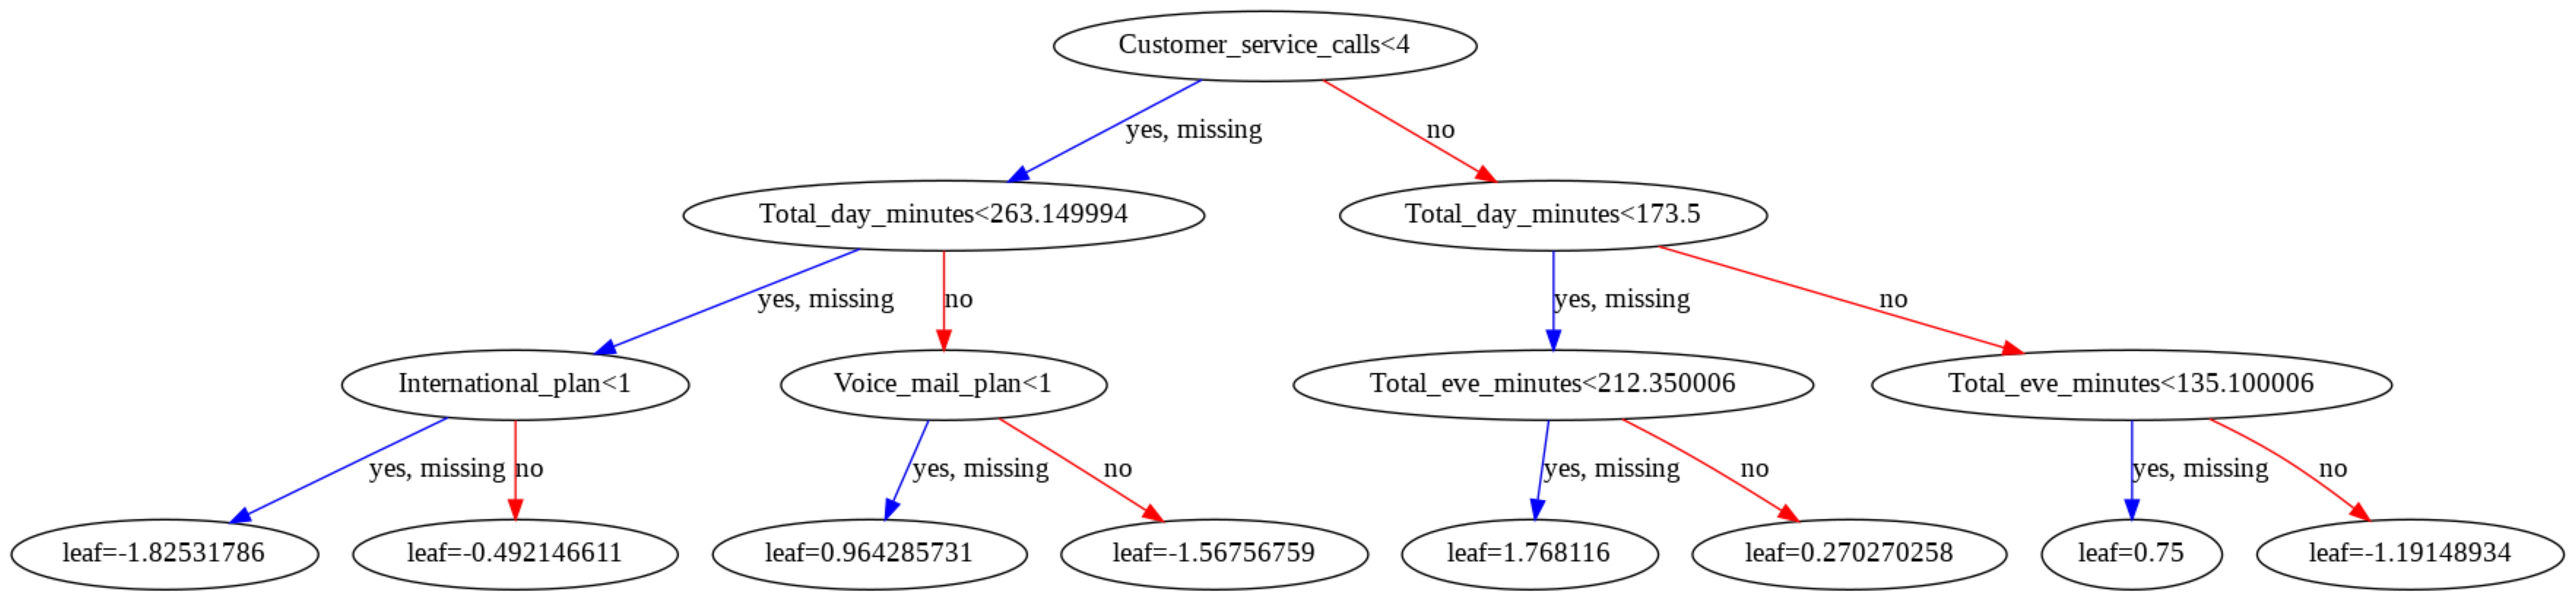

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50
plot_tree(xgb_model)
plt.show()

In [ ]:
preds_prob = xgb_model.predict(dtest)

In [ ]:
predicted_labels = preds_prob > 0.5
print(
    "Accuracy and F1 on the test set are: {} and {}".format(
        round(accuracy_score(y_test, predicted_labels), 3),
        round(f1_score(y_test, predicted_labels), 3),
    )
)
print(
    "Precision and recall on the test set are: {} and {}".format(
        round(precision_score(y_test, predicted_labels), 3),
        round(recall_score(y_test, predicted_labels), 3),
    )
)

ValueError: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import vstack
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, validation_curve
from xgboost.sklearn import XGBClassifier

**Генерируем синтетические данные.**

In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=3,
    n_repeated=2,
    random_state=42,
)

**Будем проводить 10-кратную стратифицированную кросс-валидацию. По умолчанию в статьях по машинному обучению и статистике используется именно такая.**

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**Посмотрим, как число деревьев влияет на качество модели.**

In [ ]:
n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(objective = "binary:logistic", max_depth = 1, learning_rate = 0.3, seed = 42),
    X, y,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X, y),
    scoring="accuracy",
    n_jobs=-1,
)

In [ ]:
n_estimators_range

array([  1,  23,  45,  67,  89, 111, 133, 155, 177, 200])

In [ ]:
train_scores

**Построим кривые валидации.**

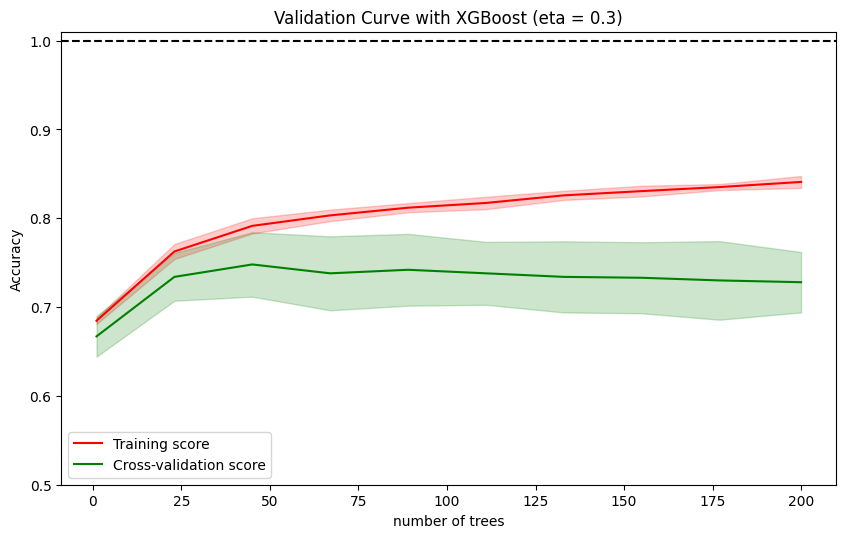

Best cross-validation result (0.75) obtained for 45 trees


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range, test_scores_mean, label="Cross-validation score", color="g"
)

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)

Что заметно:

<br>Доля правильных ответов на обучении продолжает расти, хотя на валидации - уже нет
<br>Когда деревьев меньше 25 разброс (variance) ошибки невелик, но и смещение (bias) велико
<br>Начиная с 25 деревьев, разброс ошибки начинает расти
<br>Модель доаольно стабильна: дальнейшее увеличение ее сложности не приводит к увеличению разброса ошибки.
<br>Оптимальное в данном случае сочетание разброса и смещение наблюдается примерно при 50 итерациях. Хотя разброс все же велик.

Что можно улучшить?
<br>Снижение разброса
<br>**Для уменьшения сложности модели можно:**

<br>использовать меньше признаков (например, отбор)
<br>использовать больше объектов (например, искусственно созданных)
<br>увеличить регуляризацию
<br>В случае XGBoost можно:

<br>уменьшать максимальную глубину деревьев(max_depth)
<br>увеличивать значение параметра min_child_weight
<br>увеличивать значение параметра gamma
<br>добавлять больше "случайности" за счет параметров subsample и colsample_bytree
<br>увеличивать значение паарметров регуляризации lambda и alpha
<br>Снижение смещения
<br>
<br>**Если модель слишком простая, можно:**

<br>добавлять больше признаков (например, изобретать их),
<br>усложнять модель
<br>уменьшать регуляризацию
<br>В случае XGBoost можно:

<br>увеличивать максимальную глубину деревьев(max_depth)
<br>уменьшать значение параметра min_child_weight
<br>уменьшать значение параметра gamma
<br>уменьшать значение параметров регуляризации lambda и alpha

Попробуем немного настроить параметры. Будем для построения каждого дерева использовать в среднем 70% случайно выбранных объектов и 60% случайно выбранных признаков. Это уменьшит разброс ошибки. Для уменьшения смещения увеличим на 1 максимальную глубину деревьев.

In [ ]:
n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(objective = "binary:logistic", max_depth = 2, learning_rate = 0.3,
    colsample_bytree = 0.6, subsample =  0.7, seed =42),
    X, y,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X, y),
    scoring="accuracy",
)

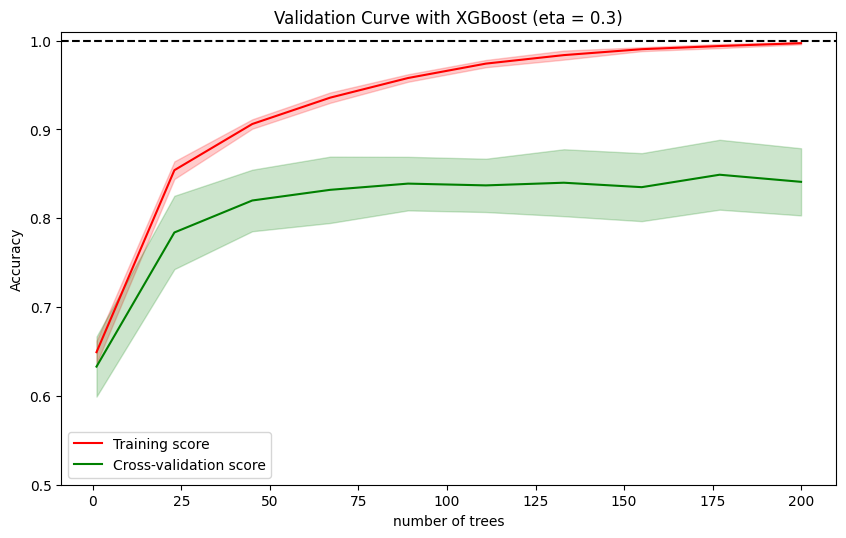

Best cross-validation result (0.85) obtained for 177 trees


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range, test_scores_mean, label="Cross-validation score", color="g"
)

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)

#Kaggle Forest Cover Type Prediction

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_csv("/content/train.csv.zip")
test_df = pd.read_csv("/content/test.csv.zip")

In [ ]:
train_df.shape, test_df.shape

((15120, 56), (565892, 55))

In [ ]:
def write_to_submission_file(
    predicted_labels, out_file, target="Cover_Type", index_label="Id", init_index=15121
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(init_index, predicted_labels.shape[0] + init_index),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

Создаем признаки.

In [ ]:
train_df["Under_water"] = train_df.Vertical_Distance_To_Hydrology < 0
test_df["Under_water"] = test_df.Vertical_Distance_To_Hydrology < 0
train_df["EVDtH"] = train_df.Elevation - train_df.Vertical_Distance_To_Hydrology
test_df["EVDtH"] = test_df.Elevation - test_df.Vertical_Distance_To_Hydrology

train_df["EHDtH"] = train_df.Elevation - train_df.Horizontal_Distance_To_Hydrology * 0.2
test_df["EHDtH"] = test_df.Elevation - test_df.Horizontal_Distance_To_Hydrology * 0.2

In [ ]:
train_df["Distanse_to_Hydrolody"] = (
    train_df["Horizontal_Distance_To_Hydrology"] ** 2
    + train_df["Vertical_Distance_To_Hydrology"] ** 2
) ** 0.5
test_df["Distanse_to_Hydrolody"] = (
    test_df["Horizontal_Distance_To_Hydrology"] ** 2
    + test_df["Vertical_Distance_To_Hydrology"] ** 2
) ** 0.5

train_df["Hydro_Fire_1"] = (
    train_df["Horizontal_Distance_To_Hydrology"]
    + train_df["Horizontal_Distance_To_Fire_Points"]
)
test_df["Hydro_Fire_1"] = (
    test_df["Horizontal_Distance_To_Hydrology"]
    + test_df["Horizontal_Distance_To_Fire_Points"]
)

train_df["Hydro_Fire_2"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    - train_df["Horizontal_Distance_To_Fire_Points"]
)
test_df["Hydro_Fire_2"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    - test_df["Horizontal_Distance_To_Fire_Points"]
)

train_df["Hydro_Road_1"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    + train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Hydro_Road_1"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    + test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Hydro_Road_2"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    - train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Hydro_Road_2"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    - test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Fire_Road_1"] = abs(
    train_df["Horizontal_Distance_To_Fire_Points"]
    + train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Fire_Road_1"] = abs(
    test_df["Horizontal_Distance_To_Fire_Points"]
    + test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Fire_Road_2"] = abs(
    train_df["Horizontal_Distance_To_Fire_Points"]
    - train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Fire_Road_2"] = abs(
    test_df["Horizontal_Distance_To_Fire_Points"]
    - test_df["Horizontal_Distance_To_Roadways"]
)

In [ ]:
y = train_df["Cover_Type"]
train_df = train_df.drop(["Cover_Type", "Id"], axis=1)
test_df = test_df.drop(["Id"], axis=1)

In [ ]:
train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Under_water,EVDtH,EHDtH,Distanse_to_Hydrolody,Hydro_Fire_1,Hydro_Fire_2,Hydro_Road_1,Hydro_Road_2,Fire_Road_1,Fire_Road_2
0,2596,51,3,258,0,510,221,232,148,6279,...,False,2596,2544.4,258.000000,6537,6021,768,252,6789,5769
1,2590,56,2,212,-6,390,220,235,151,6225,...,True,2596,2547.6,212.084889,6437,6013,602,178,6615,5835
2,2804,139,9,268,65,3180,234,238,135,6121,...,False,2739,2750.4,275.769832,6389,5853,3448,2912,9301,2941
3,2785,155,18,242,118,3090,238,238,122,6211,...,False,2667,2736.6,269.235956,6453,5969,3332,2848,9301,3121
4,2595,45,2,153,-1,391,220,234,150,6172,...,True,2596,2564.4,153.003268,6325,6019,544,238,6563,5781


In [ ]:
y.unique()

array([5, 2, 1, 7, 3, 6, 4])

In [ ]:
y = y - 1  # Чтоб классы нумеровались от о до 6

In [ ]:
y.unique()

array([4, 1, 0, 6, 2, 5, 3])

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
def score(params):
    from sklearn.metrics import log_loss

    print("Training with params:")
    print(params)
    params["max_depth"] = int(params["max_depth"])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params["num_round"])
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 7))
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {"loss": score, "status": STATUS_OK}

In [ ]:
def optimize(trials):
    space = {
        "num_round": 100,
        "learning_rate": hp.quniform("eta", 0.005, 0.05, 0.005),
        "max_depth": hp.quniform("max_depth", 3, 14, 1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "num_class": 7,
        "eval_metric": "merror",
        "objective": "multi:softprob",
        "nthread": 8
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.3, random_state=17
)

In [ ]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'merror', 'gamma': 0.91, 'learning_rate': 0.035, 'max_depth': 5.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'subsample': 0.7000000000000001}
	Score 0.6229591157896743


Training with params:
{'colsample_bytree': 0.9500000000000001, 'eval_metric': 'merror', 'gamma': 0.62, 'learning_rate': 0.03, 'max_depth': 4.0, 'min_child_weight': 1.0, 'nthread': 8, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'subsample': 0.55}
	Score 0.7050340849909491


Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'merror', 'gamma': 0.6, 'learning_rate': 0.015, 'max_depth': 13.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'subsample': 0.9}
	Score 0.7176362012284668


Training with params:
{'colsample_bytree': 0.65, 'eval_metric': 'merror', 'gamma': 0.9400000000000001, 'learning_rate': 0.01, 'max

{'colsample_bytree': 1.0,
 'eta': 0.04,
 'gamma': 0.72,
 'max_depth': 8.0,
 'min_child_weight': 4.0,
 'subsample': 0.6000000000000001}

In [ ]:
best_params["max_depth"] = int(best_params["max_depth"])
best_params["num_class"] = 7
best_params["eval_metric"] = "merror"
best_params["objective"] = "multi:softprob"
best_params["nthread"] = 4
best_params["silent"] = 1

In [ ]:
dtrain = xgb.DMatrix(train_df, y)

In [ ]:
%%time
xgbCvResult = xgb.cv(
    best_params, dtrain, num_boost_round=500, nfold=3, early_stopping_rounds=50
)

CPU times: user 13min 13s, sys: 13.8 s, total: 13min 27s
Wall time: 9min 26s


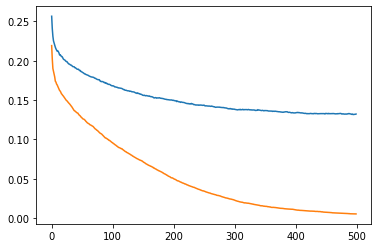

In [ ]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-merror-mean"])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-merror-mean"]);

In [ ]:
best_num_round = np.argmin(xgbCvResult["test-merror-mean"])
best_num_round

494

**Сделаем прогноз для всей тестовой выборки.**

In [ ]:
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)

In [ ]:
dtest = xgb.DMatrix(test_df)

In [ ]:
xgboost_predict_proba = bestXgb.predict(dtest)

In [ ]:
xgboost_prediction = np.argmax(xgboost_predict_proba, axis=1)

**Мы вычитали из целевых меток 1, теперь добавляем.**

In [ ]:
xgboost_prediction += 1

In [ ]:
write_to_submission_file(xgboost_prediction, "forest_cover_type_xgboost.csv")

Использование встроенных метрик
<br>В Xgboost реализованы большинство популярных метрик для классификации, регрессии и ранжирования:
<br><li>rmse - root mean square error</li>
<br><li>mae - mean absolute error</li>
<br><li>logloss - negative log-likelihood</li>
<br><li>error (по умолчанию) - доля ошибок в бинарной классификации</li>
<br><li>merror - доля ошибок в классификации на несколько классов</li>
<br><li>auc - area under curve</li>
<br><li>ndcg - normalized discounted cumulative gain</li>
<br><li>map - mean average precision</li>

In [ ]:
#Чтоб отслеживать log_loss, просто добавим ее в словарь params.
params["eval_metric"] = "logloss"
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

ValueError: ignored

In [ ]:
#Можно отслеживать сразу несколько метрик.
params["eval_metric"] = ["logloss", "auc"]
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

ValueError: ignored

**Несбалансированные выборки**

Сгенерируем несбалансированную выборку для задачи классификации.

In [ ]:
X, y = make_classification(
    n_samples=200,
    n_features=5,
    n_informative=3,
    n_classes=2,
    weights=[0.9, 0.1],
    shuffle=True,
    random_state=123,
)

print("There are {} positive instances.".format(y.sum()))

There are 20 positive instances.


**Разбиваем на обучающую и тестовую выборки. Соблюдаем стратификацию.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=123
)

print("Train set labels distibution: {}".format(np.bincount(y_train)))
print("Test set labels distibution:  {}".format(np.bincount(y_test)))

Train set labels distibution: [121  13]
Test set labels distibution:  [59  7]


**В начале игнорируем то, что выборка несбалансированная.**

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

**Инициализируем параметры Xgboost - будем обучать композицию из 15 "пеньков".**

In [ ]:

params = {"objective": "binary:logistic", "max_depth": 1, "silent": 1, "eta": 1}

num_rounds = 15

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")

**Матрица ошибок.**

In [ ]:
pd.crosstab(
    pd.Series(y_test, name="Actual"),
    pd.Series(y_test_preds, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0,58,1,59
1,5,2,7
All,63,3,66


**Доля правильных ответов, точность и полнота.**

In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision: {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall: {0:.2f}".format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.67
Recall: 0.29


**Видно, что полнота низкая. то есть алгоритм плохо распознает объекты мало представленного класса. Если интересно находить как раз такие редкие объекты, то от такого алгоритма мало толку.**

**Задание весов вручную
При создании объекта DMatrix можно сразу явно указать, что вес положительных объектов в 5 раз больше, чем отрицательных.**

In [ ]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)  # weights added
dtest = xgb.DMatrix(X_test)

**Повторим обучение модели, как и в предыдущем случае.**

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")

In [ ]:
pd.crosstab(
    pd.Series(y_test, name="Actual"),
    pd.Series(y_test_preds, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0,57,2,59
1,4,3,7
All,61,5,66


In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision: {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall: {0:.2f}".format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.60
Recall: 0.43


**Видим, что вес объектов надо настраивать в зависимости от задачи.**

**Параметр scale_pos_weight в Xgboost
Задание весов вручную можно заменить на параметр scale_pos_weight**

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

Инициализируем параметр scale_pos_weight соотношением числа отрицательных и положительных объектов.

In [ ]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params["scale_pos_weight"] = ratio

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")

pd.crosstab(
    pd.Series(y_test, name="Actual"),
    pd.Series(y_test_preds, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0,56,3,59
1,4,3,7
All,60,6,66


In [ ]:

print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision: {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall: {0:.2f}".format(recall_score(y_test, y_test_preds)))

Accuracy: 0.89
Precision: 0.50
Recall: 0.43


**В этом случае значение параметра scale_pos_weight надо выбирать в зависимости от желаемого соотношения между точностью и полнотой.**

**Пример с оттоком клиентов телеком-компании
Загрузим данные и осуществим минимальную предобработку.**

In [ ]:
url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/'
df = pd.read_csv(url + 'telecom_churn.csv')

**Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.**

In [ ]:
state_enc = LabelEncoder()
df["State"] = state_enc.fit_transform(df["State"])
df["International plan"] = (df["International plan"] == "Yes").astype("int")
df["Voice mail plan"] = (df["Voice mail plan"] == "Yes").astype("int")
df["Churn"] = (df["Churn"]).astype("int")

**Видим, что соотношение хороших и плохих клиентов примерно 6:1.**

In [ ]:
df["Churn"].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

**Разделим данные на обучающую и тестовую выборки в отношении 7:3 с учетом соотношения классов. Инициализируем соотв. объекты DMatrix dtrain и dtest.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Churn", axis=1),
    df["Churn"],
    test_size=0.3,
    stratify=df["Churn"],
    random_state=42,
)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [ ]:
params = {"objective": "binary:logistic", "max_depth": 4, "silent": 1, "eta": 0.3}

num_rounds = 100

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)

In [ ]:
preds_prob = xgb_model.predict(dtest)
pred_labels = (preds_prob > 0.5).astype("int")

In [ ]:
pd.crosstab(
    pd.Series(dtest.get_label(), name="Actual"),
    pd.Series(pred_labels, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0.0,843,12,855
1.0,35,110,145
All,878,122,1000


In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(dtest.get_label(), pred_labels)))
print("Precision: {0:.2f}".format(precision_score(dtest.get_label(), pred_labels)))
print("Recall: {0:.2f}".format(recall_score(dtest.get_label(), pred_labels)))
print("F1: {0:.2f}".format(f1_score(dtest.get_label(), pred_labels)))

Accuracy: 0.95
Precision: 0.90
Recall: 0.76
F1: 0.82


**Теперь изменим параметр scale_pos_weight и проделаем то же самое.**

In [ ]:
params["scale_pos_weight"] = 10

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)

In [ ]:
preds_prob = xgb_model.predict(dtest)
pred_labels = (preds_prob > 0.5).astype("int")

In [ ]:
pd.crosstab(
    pd.Series(dtest.get_label(), name="Actual"),
    pd.Series(pred_labels, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0.0,821,34,855
1.0,29,116,145
All,850,150,1000


In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(dtest.get_label(), pred_labels)))
print("Precision: {0:.2f}".format(precision_score(dtest.get_label(), pred_labels)))
print("Recall: {0:.2f}".format(recall_score(dtest.get_label(), pred_labels)))
print("F1: {0:.2f}".format(f1_score(dtest.get_label(), pred_labels)))

Accuracy: 0.94
Precision: 0.77
Recall: 0.80
F1: 0.79


**Видим, что таким образом мы настроили модель так, что она меньше ошибается в распознавании плохих клиентов.**

#2 Task

In [ ]:
%%time 
import numpy as np
#b = str(input())
b = "AB"
while b == ' ':
  b = str(input())

lst = []
for i in b:
  lst.append(i)

n = len(np.unique(np.array(lst)))

print(n ** len(b))

#3 Task

In [ ]:
N = 2
p = 50

In [ ]:
x1, x2 = -76, 96

In [ ]:
x1*n1 + x2*n2 + p = 100


In [ ]:
-0.76 * n1 + 0.96 * n2 + p = 100
n1 = 100 - 50 + 0.96/0,76 * n2

In [ ]:
0 * x1 + 0 * x2 + p = 50
1 * x1 + 0 * x2 + p = -26  # not insane
0 * x1 + 1 * x2 + p = 146
1 * x1 + 1 * x2 + p = 76   # not insane

In [ ]:
x * -0.76 + y * 0.96 = 50
y = (50 + 0.76 * x) / 0.96

In [ ]:
y + x = 1.09090909091
x = y - 1.09090909091
y - 1.09090909091

In [ ]:
%%time
total = []
for j in range(100000):
  sum = 0
  N = np.random.randint(low = 1, high = 20)
  for i in range(1, N + 1):
    sum += np.random.randint(low = -5, high = 5) * np.random.randint(low=-100, high=100) + np.random.randint(low=1, high=100)

  total.append(sum)

In [ ]:
%%time
np.mean(total)

#4 task

In [ ]:
n = 7
q = []
for i in range(n):
  q.append(np.random.randint(0, 10))

In [ ]:
q

In [ ]:
m = 1

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linreg = LinearRegression()
f = array(i for i in range(7))

In [ ]:
linreg.fit(f.reshape(-1,1), q.reshape(-1,1))